In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import statsmodels.stats.api as sms

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
! gdown --id 1ZRnWZfDuJMNAeXSZXbFcDhiY88P_F1W3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZRnWZfDuJMNAeXSZXbFcDhiY88P_F1W3
To: /content/HeyJobs - Product Analyst Assessment - Dataset.csv
100% 25.5M/25.5M [00:00<00:00, 215MB/s]


In [ ]:
df = pd.read_csv('/content/HeyJobs - Product Analyst Assessment - Dataset.csv')

In [ ]:
df.head(2)

,session_start_ts,session_id,device_type,user_token,experiment_group,submitted_applications
0,2022-04-14 18:07:32.361000,108912c7f8c8635443af0d9958ed2395119dcfc7,Mobile,62e9202bbbc1bd27c9696be104d25f1ed6485564,FEATURED_JOBS_VARIANT,0
1,2022-04-14 12:08:34.421000,80059df9280ac7163afcb5852c87df721101686e,Mobile,68693ced9e954bef7abf96a5d9f6557d8c7cc027,ORIGINAL_VARIANT,0


In [ ]:
df["date"]=  df["session_start_ts"].apply(lambda x: str(x)[:10])


In [ ]:
df.submitted_applications.value_counts()

0     176071
1       7008
2       1515
3        109
4         32
5         16
6         10
7          3
8          3
9          2
11         1
39         1
20         1
26         1
12         1
Name: submitted_applications, dtype: int64

In [ ]:
df.submitted_applications.describe()

count    184774.000000
mean          0.058471
std           0.312570
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: submitted_applications, dtype: float64

In [ ]:
df.shape

(184774, 6)

**Data cleaning**

In [ ]:
# Remove outliers
# It is pretty arguable - should we clean outliers in A/B-tests or not. I prefer to clean
df = df[df.submitted_applications < 10]

In [ ]:
df.submitted_applications.describe()

count    184769.000000
mean          0.057888
std           0.286846
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.000000
Name: submitted_applications, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184769 entries, 0 to 184773
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   session_start_ts        184769 non-null  object
 1   session_id              184769 non-null  object
 2   device_type             184769 non-null  object
 3   user_token              184769 non-null  object
 4   experiment_group        184769 non-null  object
 5   submitted_applications  184769 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 9.9+ MB


In [ ]:
df.experiment_group.value_counts()

FEATURED_JOBS_VARIANT    93009
ORIGINAL_VARIANT         91760
Name: experiment_group, dtype: int64

**Analysis**

In [ ]:
control_sample = df[df['experiment_group'] == 'ORIGINAL_VARIANT']
treatment_sample = df[df['experiment_group'] == 'FEATURED_JOBS_VARIANT']

In [ ]:
print('Control shape:', control_sample.shape)
print('Treatment shape:', treatment_sample.shape)

Control shape: (91760, 6)
Treatment shape: (93009, 6)


In [ ]:
control_sample.submitted_applications.mean()

0.05677855274629468

In [ ]:
control_sample.groupby('device_type').submitted_applications.describe()

,count,mean,std,min,25%,50%,75%,max
device_type,,,,,,,,
Computer,17920.0,0.056027,0.286784,0.0,0.00,0.0,0.00,7.0
Digital media receiver,2.0,0.500000,0.707107,0.0,0.25,0.5,0.75,1.0
Game console,1.0,0.000000,NaN,0.0,0.00,0.0,0.00,0.0
Mobile,72570.0,0.057296,0.282166,0.0,0.00,0.0,0.00,8.0
Tablet,1256.0,0.037420,0.217265,0.0,0.00,0.0,0.00,3.0
Unknown,11.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [ ]:
treatment_sample.submitted_applications.mean()

0.0589835392273866

In [ ]:
treatment_sample.groupby('device_type').submitted_applications.describe()

,count,mean,std,min,25%,50%,75%,max
device_type,,,,,,,,
Computer,15714.0,0.074392,0.355520,0.0,0.0,0.0,0.0,9.0
Digital media receiver,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
Game console,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Mobile,76367.0,0.055980,0.276768,0.0,0.0,0.0,0.0,6.0
Tablet,907.0,0.046307,0.235050,0.0,0.0,0.0,0.0,2.0
Unknown,13.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
control_sample.submitted_applications.sum()

5210

In [ ]:
treatment_sample.submitted_applications.sum()

5486

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = control_sample['submitted_applications']
treatment_results = treatment_sample['submitted_applications']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.mean(), treatment_results.mean()]
nobs = [n_con, n_treat]

In [ ]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [ ]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.07
p-value: 0.940
ci 95% for control group: [0.000, 0.000]
ci 95% for treatment group: [0.000, 0.000]


Computer check

In [ ]:
control_sample_computer = control_sample[control_sample.device_type == 'Computer']
control_sample_computer.shape

(17920, 6)

In [ ]:
treatment_sample_computer = treatment_sample[treatment_sample.device_type == 'Computer']
treatment_sample_computer.shape

(15714, 6)

In [ ]:
control_results = control_sample_computer['submitted_applications']
treatment_results = treatment_sample_computer['submitted_applications']

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.mean(), treatment_results.mean()]
nobs = [n_con, n_treat]

In [ ]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [ ]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.07
p-value: 0.940
ci 95% for control group: [0.000, 0.000]
ci 95% for treatment group: [0.000, 0.000]


In [ ]:
df["date"]=  df["session_start_ts"].apply(lambda x: str(x)[:10])

In [ ]:
df.head(2)

,session_start_ts,session_id,device_type,user_token,experiment_group,submitted_applications,date
0,2022-04-14 18:07:32.361000,108912c7f8c8635443af0d9958ed2395119dcfc7,Mobile,62e9202bbbc1bd27c9696be104d25f1ed6485564,FEATURED_JOBS_VARIANT,0,2022-04-14
1,2022-04-14 12:08:34.421000,80059df9280ac7163afcb5852c87df721101686e,Mobile,68693ced9e954bef7abf96a5d9f6557d8c7cc027,ORIGINAL_VARIANT,0,2022-04-14


In [ ]:
all_data_day_count = df.groupby('date').submitted_applications.count()

In [ ]:
all_data_day_count = pd.DataFrame(data=all_data_day_count)
all_data_day_count = all_data_day_count.reset_index()

In [ ]:
all_data_day_count

,date,submitted_applications
0,2022-04-13,13933
1,2022-04-14,28097
2,2022-04-15,25217
3,2022-04-16,18073
4,2022-04-17,19006
5,2022-04-18,24574
6,2022-04-19,33358
7,2022-04-20,22516


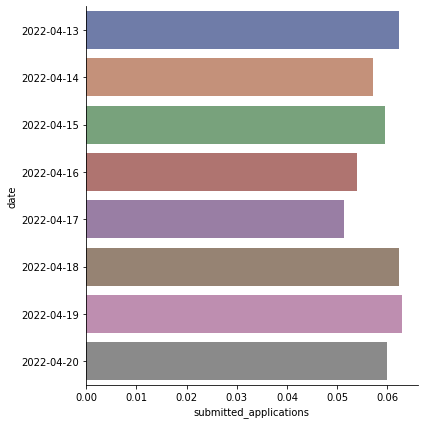

In [ ]:
g = sns.catplot(
    data=all_data_day_count, kind="bar",
    x="submitted_applications", y="date",
    ci="sd", palette="dark", alpha=.6, height=6)

In [ ]:
# Control
control_sample["date"]=  control_sample["session_start_ts"].apply(lambda x: str(x)[:10])
all_data_day_count = control_sample.groupby('date').submitted_applications.mean()
all_data_day_count = pd.DataFrame(data=all_data_day_count)
all_data_day_count = all_data_day_count.reset_index()
all_data_day_count

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,submitted_applications
0,2022-04-13,0.051840
1,2022-04-14,0.053200
2,2022-04-15,0.053980
3,2022-04-16,0.055469
4,2022-04-17,0.057645
5,2022-04-18,0.055300
6,2022-04-19,0.062924
7,2022-04-20,0.060308


In [ ]:
# Test
treatment_sample["date"]=  treatment_sample["session_start_ts"].apply(lambda x: str(x)[:10])
all_data_day_count = treatment_sample.groupby('date').submitted_applications.mean()
all_data_day_count = pd.DataFrame(data=all_data_day_count)
all_data_day_count = all_data_day_count.reset_index()
all_data_day_count

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,submitted_applications
0,2022-04-13,0.062216
1,2022-04-14,0.057115
2,2022-04-15,0.059602
3,2022-04-16,0.053982
4,2022-04-17,0.051346
5,2022-04-18,0.062275
6,2022-04-19,0.062868
7,2022-04-20,0.059877


PART 2

In [ ]:
effect_size = sms.proportion_effectsize(0.056, 0.1)

In [ ]:
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1)
round(required_n)

572